# Learning Position Auctions

In this tutorial, we will extend the ideas from the [previous tutorial](learning-auctions-interdependence.ipynb).  We will consider position auctions, like those found in paid search marketplaces.

## Motivating example

Consider a three-bidder, two-slot position auction where the values for the three bidders are correlated.  There is a signal $c\sim U[0,1]$, which we intepret as a _conversion rate_.  The value of the item for bidder 1 is a random variable $v_1 = x_1 c$ where $x_1 \sim U[0,1]$, similarly for bidder 2 and bidder 3 with independent $x_i \sim U[0,1]$.

The first slot has a click-through-rate (quality) of 1.  The second slot has a click-through-rate of 0.5.  A bidder may purchase one slot only, so we can consider this a special case of a multi-item, unit-demand scenario.

## Architectures and supporting functions

As in the previous tutorial, we will make use of RegretNet.

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

We add common `dmch` components:

In [3]:
import dmch
from dmch import Mechanism
from dmch import SequentialMechanism
from dmch import create_spa_mechanism

Now we define the auction scenario:

In [4]:
# Number of bidders
bidders = 2

# Pr(click|position)
slot_weights = [1, 0.5]

# Number of slots
slots = len(slot_weights)


## GSP

For comparison, we define the GSP mechanism by using sequantial second-price auctions (SPA):

In [5]:
def create_gsp_mechanism():
    return SequentialMechanism(
        [create_spa_mechanism(bidders) for _ in range(len(slot_weights))],
        bidders=bidders,
        weights=slot_weights)

## RegretNet

The allocation network is defined as follows:

In [6]:
def create_position_regret_net(bidders, hidden_layers=2, hidden_units=10, use_residuals=False, act_layer=nn.Sigmoid):
    mbuilder = dmch.build_mechanism(bidders)
    
    # create a layer to correctly size the hidden layers
    mbuilder.allocation_builder.add_linear_layer(hidden_units)
    mbuilder.payment_builder.add_linear_layer(hidden_units)
    
    for _ in range(hidden_layers):
        if use_residuals:
            mbuilder.allocation_builder.add_residual_layer(act_layer=act_layer)
            mbuilder.payment_builder.add_residual_layer(act_layer=act_layer)
        else:
            mbuilder.allocation_builder.add_linear_layer(hidden_units)
            mbuilder.payment_builder.add_linear_layer(hidden_units)
            mbuilder.allocation_builder.add_activation(act_layer())
            mbuilder.payment_builder.add_activation(act_layer())
    
    return mbuilder.build_sequential(slots,weights=slot_weights)

## Auction for the motivating example



The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [7]:
import torch.utils.data as data_utils

sample_size = 2**11
batch_size = 2**8
epochs = 1000

inputs = torch.rand(sample_size, bidders)

eval_inputs = torch.rand(sample_size, bidders)

inputs_loader=data_utils.DataLoader(
    data_utils.TensorDataset(inputs),
    batch_size=batch_size)

eval_inputs_loader=data_utils.DataLoader(
    data_utils.TensorDataset(eval_inputs),
    batch_size=batch_size)

Before training the networks, let's establish a GSP baseline.

In [8]:
gsp = create_gsp_mechanism()
gsp_report = pd.DataFrame(
    dmch.evaluate(
        gsp,
        inputs_loader,
        bidders,
        epochs=epochs,
        device=device,
        misreport_lr=1e-1,
        misreport_epochs=100))

We now create a simple RegretNet instance.

In [9]:
regret_net = create_position_regret_net(bidders).to(device)

We loop over the data for a number of epochs and record traces of the networks learning.

In [10]:
regret_net_report = pd.DataFrame(
    dmch.train(
        regret_net,
        inputs_loader,
        bidders,
        epochs=epochs,
        device=device,
        rho=1e2,
        mechanism_lr=1e-2,
        misreport_lr=1e-1,
        misreport_epochs=10))

100%|██████████| 1000/1000 [31:53<00:00,  1.32s/it]


Next, let's review the DSIC violations of the network. In the figure below, we can see that networks have a large initial violation then quickly finds a region with low and decreasing violation.

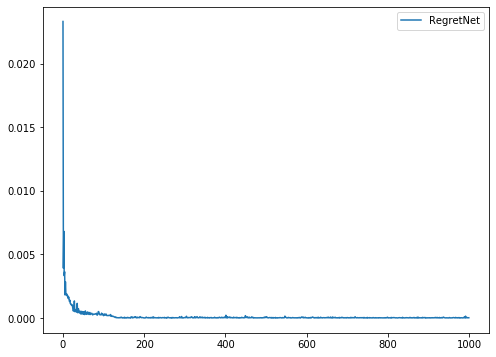

In [11]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_report.groupby('epoch').mean()[['total_ir_violation']], label='RegretNet');
ax.legend();

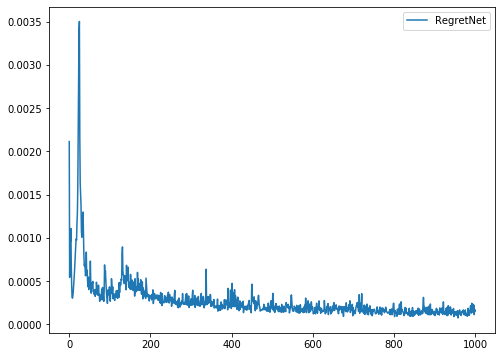

In [12]:
fig, ax = plt.subplots(figsize=(8,6));
#ax.axhline(y=gsp_report.mean()[['total_dsic_violation']].values);
ax.plot(regret_net_report.groupby('epoch').mean()[['total_dsic_violation']], label='RegretNet');
ax.legend();

Let's construct a evaluation data set.

In [13]:
regret_net_eval_report = pd.DataFrame(
    dmch.evaluate(
        regret_net,
        eval_inputs_loader,
        bidders,
        device=device,
        misreport_lr=1e-1,
        misreport_epochs=100))

The validated stats are as follows:

In [14]:
regret_net_eval_report.describe()

,batch,revenue,total_dsic_violation,total_ir_violation
count,8.00000,8.000000,8.000000,8.000000
mean,3.50000,0.482951,0.000528,0.000032
std,2.44949,0.014231,0.000123,0.000017
min,0.00000,0.462440,0.000326,0.000010
25%,1.75000,0.474625,0.000498,0.000023
50%,3.50000,0.484496,0.000559,0.000029
75%,5.25000,0.495181,0.000587,0.000042
max,7.00000,0.498430,0.000692,0.000057


We can compare this to the Myerson mechanism.

In [15]:
def myerson():
    sorted_inputs,_ = torch.cat((inputs, torch.zeros(inputs.shape)),dim=1).sort(dim=1, descending=True)
    virtual_inputs = 2*sorted_inputs-1
    virtual_payments = (virtual_inputs[:,0:2]>=0).float() * (F.relu(virtual_inputs[:,1:3]))
    payments = (virtual_inputs[:,0:2]>=0).float()*((virtual_payments+1)/2)
    payments = payments[:,0] + 0.5 * payments[:,1]
    return payments.mean().cpu().numpy()

Let's review the revenue of the network: RegretNet exceeds GSP revenue with less violation and approaches Myerson revenue.

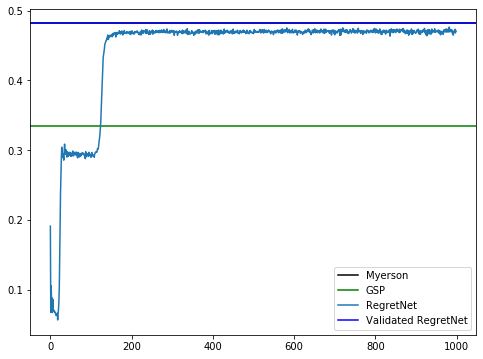

In [16]:
fig, ax = plt.subplots(figsize=(8,6));
ax.axhline(y=myerson(), label='Myerson', color='k');
ax.axhline(y=gsp_report.mean()[['revenue']].values, color='g', label='GSP');
ax.plot(regret_net_report.groupby('epoch').mean()[['revenue']], label='RegretNet');
ax.axhline(y=regret_net_eval_report[['revenue']].mean()[0], color='b', label='Validated RegretNet')
ax.legend();

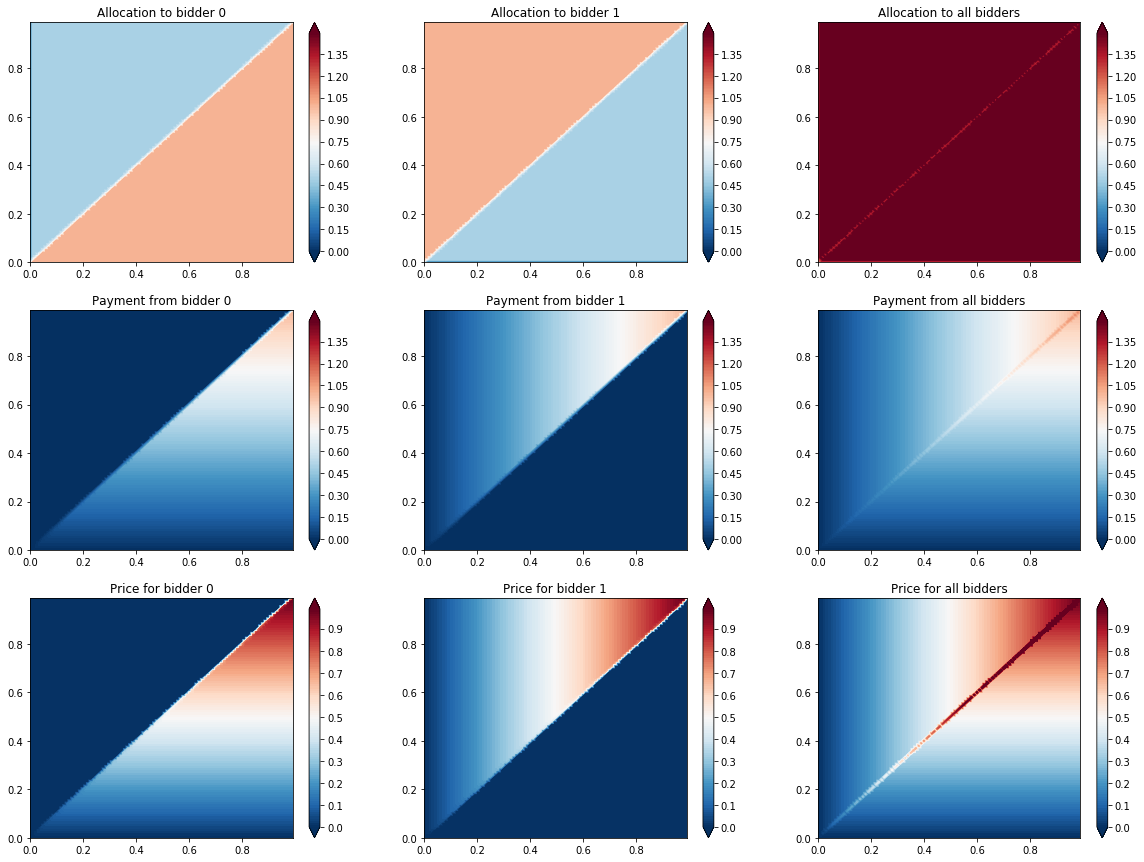

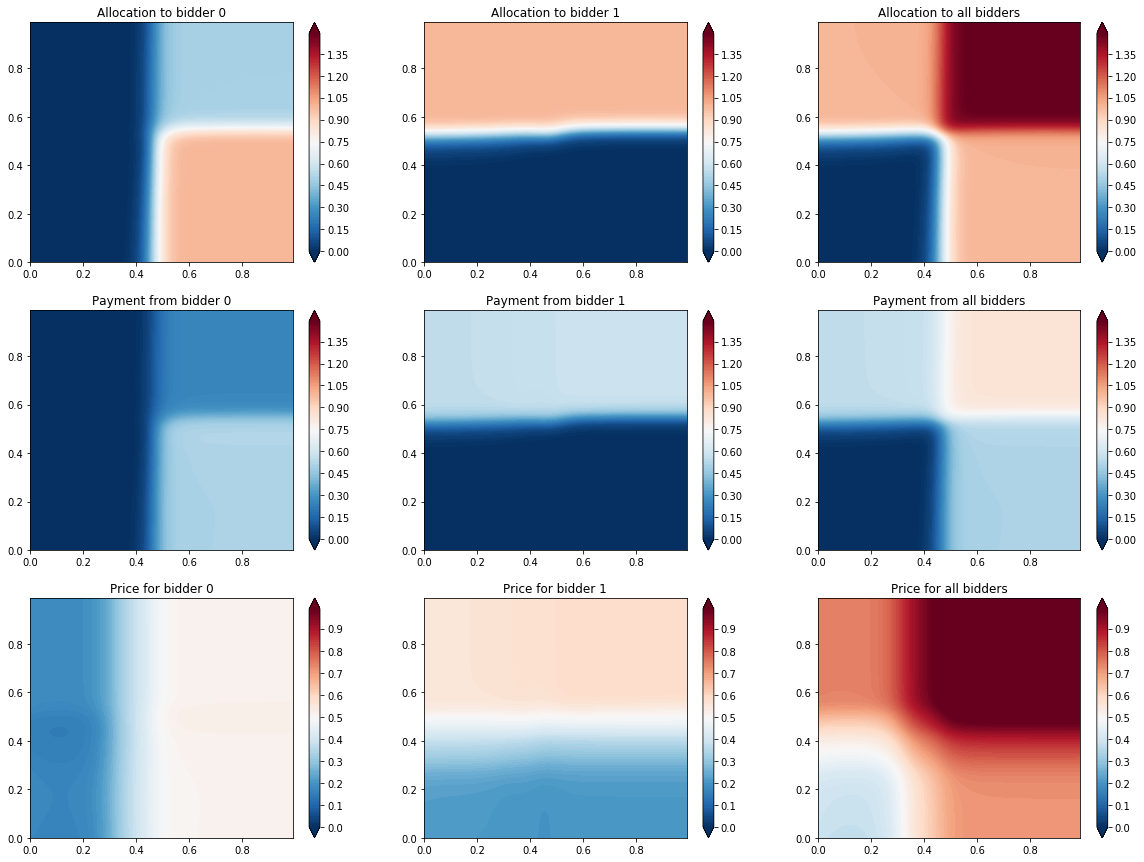

In [17]:
def plot_mechanism(mechanism):
    X, Y = np.meshgrid(
        np.arange(0.0, 1.0, 0.01),
        np.arange(0.0, 1.0, 0.01))
    
    inputs = torch.cat(
        (torch.from_numpy(np.reshape(X, (100*100,1))),
         torch.from_numpy(np.reshape(Y, (100*100,1)))),
        dim=1).float().to(device)
    allocation, payment = mechanism(inputs)
    allocation_levels = np.arange(0, 1.5, 0.01)
    bid_levels = np.arange(0, 1.0, 0.01)
    fig, axes = plt.subplots(nrows=3, ncols=bidders+1, figsize=(20,15));
    
    def plot_contour(tensor,axis_index,bidder_title,main_title,levels):
        for bidder in range(bidders):
            CS = axes[axis_index,bidder].tricontourf(
                inputs[:,0].cpu().numpy(),
                inputs[:,1].cpu().numpy(),
                tensor[:,bidder].detach().cpu().numpy(),
                levels=levels,
                cmap="RdBu_r",
                extend='both');
            fig.colorbar(CS, ax=axes[axis_index,bidder]);
            axes[axis_index,bidder].set_title(bidder_title+str(bidder));
        CS = axes[axis_index,bidders].tricontourf(
            inputs[:,0].cpu().numpy(),
            inputs[:,1].cpu().numpy(),
            tensor.sum(dim=1).detach().cpu().numpy(),
            levels=levels,
            cmap="RdBu_r",
            extend='both');
        fig.colorbar(CS, ax=axes[axis_index,bidders]);
        axes[axis_index,bidders].set_title(main_title);
    plot_contour(allocation,0,'Allocation to bidder ','Allocation to all bidders',allocation_levels)
    plot_contour(payment,1,'Payment from bidder ','Payment from all bidders',allocation_levels)
    plot_contour(payment/allocation,2,'Price for bidder ','Price for all bidders',bid_levels)
    
plot_mechanism(gsp)
plot_mechanism(regret_net)